# The Simple Bike Repositioning Scenario


In [2]:
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from math import sin
from typing import List

from maro.backends.frame import NodeAttribute, NodeBase, node, FrameBase, FrameNode
from maro.simulator.scenarios import AbsBusinessEngine
from maro.event_buffer import MaroEvents
from maro.simulator import Env

## 1. Problem Setting

To simplify this problem, we consider a situation where are only 4 bike stations. Let's denote the station set as $\{s_i|i=0,1,2,3\}$.

In [3]:
TOTAL_STATIONS = 4

The detailed trip requirement distribution among these stations are shown in the figure below. Here we use $F_{ij}(t)$ to present the trip requirements from station $s_i$ to station $s_j$.

<img src="./simple_bike_repositioning/TripRequirements.png" width="700"/>

The right half of this figure shows the trip requirement curve of each station pair $F_{ij}(t)$ over time $t$. We can find that:
- $F_{02}(t)$ and $F_{20}(t)$ follow a symmetric and periodic transition pattern. In the first half of the period, $F_{02}(t)$ first increases from 0 to the maximum and then decreases to 0, while $F_{20}(t)$ remains at 0. In the second half of the period, $F_{20}(t)$ starts to increase and then decreases, while $F_{02}(t)$ remains at 0. 
- Generally speaking, $F_{13}(t)$ and $F_{31}(t)$ remains at the same level over time, with slight fluctuations only in a few times.
- As for $F_{01}(t)$ and $F_{32}(t)$, they show stable and equal trip requirements.

Specifically, we use sine functions to model these periodic changes, that we defined:

$F_{02}(t) = \max(0, 8 \sin(0.1 t))$

$F_{20}(t) = \max(0, -8 \sin(0.1 t))$

$F_{13}(t) = 5 + \max(0, 5 \sin(0.2\pi t) - 4) + \min(0, 5 \sin(0.2\pi t) + 4)$

$F_{31}(t) = 5 + \max(0, 5 \sin(0.4 t) - 4) + \min(0, 5 \sin(0.4 t) + 4)$

$F_{01}(t) = 3$

$F_{32}(t) = 3$

In [4]:
max_0_2 = 8 # The maximum trip requirements between station 0 and station 2.
exp_1_3 = 5 # The expected trip requirements between station 1 and station 3.
const_num = 3 # The number of trip requirements from station 0 to station 1, from station 3 to station 2.

def generate_station_requirements(tick: int):
    # The number of trip requirements between station 0 and station 2 follows a sine function.
    # Specifically, it is the F20(t) and F02(t) in the figure above.
    num_between_0_2 = round(sin(0.1 * tick) * max_0_2)
    requirements_between_0_2 = [(0, 2)] * num_between_0_2 if num_between_0_2 >= 0 else [(2, 0)] * -num_between_0_2

    # The number of trip requirements between station 1 and station 3 are almostly equal (with only slight difference).
    # Specifically, it is the F13(t) and F31(t) in the figure above.
    num_1_3 = round(exp_1_3 + max(0, exp_1_3 * (sin(0.628 * tick) - 1) + 1) + min(0, exp_1_3 * (sin(0.628 * tick) + 1) - 1))
    requirements_1_3 = [(1, 3)] * num_1_3
    num_3_1 = round(exp_1_3 + max(0, exp_1_3 * (sin(0.4 * tick) - 1) + 1) + min(0, exp_1_3 * (sin(0.4 * tick) + 1) - 1))
    requirements_3_1 = [(3, 1)] * num_3_1
    
    # The number of trip requirements from station 0 to station 1 and the ones from station 3 to station 2 are equal.
    # Specifically, it is the F01(t) and F32(t) in the figure above.
    const_requirements = [(0, 1)] * const_num + [(3, 2)] * const_num

    # Randomly shuffle the order of trip requirements.
    requirements = (requirements_between_0_2 + requirements_1_3 + requirements_3_1 + const_requirements)
    random.shuffle(requirements)
    return requirements

Morever, for each trip and the bike repositioning operation, we assume that they can both be done no longer than 3 ticks. That:

In [5]:
# The maximum trip duration. Unit: tick.
maximum_duration = 3

def generate_duration():
    return random.randrange(1, maximum_duration)

To ensure the bike number in this simple scenario is almost enough for trip requirements, we should take the time for trips and repositioning operations into consideration. Along with the peak requirement and the expectation of each station pair, we can roughly figure out the total bike demand in this problem. And then distribute these bikes equally to each station.

In [6]:
bike_needed_between_0_2 = max_0_2 * maximum_duration * 2
bike_needed_between_1_3 = exp_1_3 * maximum_duration * 2
bike_needed_const = const_num * maximum_duration * 2

total_bike_needed = bike_needed_between_0_2 + bike_needed_between_1_3 + bike_needed_const

# The initial bike number in each station
INITIAL_BIKES = total_bike_needed // TOTAL_STATIONS

print(f"Total bikes needed in this scenario: {total_bike_needed}, intial station inventory: {INITIAL_BIKES}.")

Total bikes needed in this scenario: 96, intial station inventory: 24.


## 2. Simulation Logics and Implementation

To implement the simple bike repositioning scenario, we first define the class of the bike station. Here each station only contains 3 attributes:
- `bikes`: The real-time available bikes in this station.
- `shortage`: How many trip requirements is failed due to the lack of bikes till now.
- `requirements`: How many trip requirements received till now.

In [7]:
# Definition of the bike station.
# The attribute name can be used to access the environment snapshot lists.
@node("station")
class Station(NodeBase):
    bikes = NodeAttribute("i")
    shortage = NodeAttribute("i")
    requirements = NodeAttribute("i")

In MARO, we use the environment frame to save the environment status. To initialize the frame of this scenario, we need to specify how many stations we have and how many snapshots we need.

In [8]:
MAX_TICKS = 100

# Definition of the environment frame. The number of stations is given here.
class SimpleCitibikeFrame(FrameBase):
    stations = FrameNode(Station, TOTAL_STATIONS)

    def __init__(self):
        super().__init__(enable_snapshot=True, total_snapshot=MAX_TICKS)

In MARO, the simulator is driven by the generation and the processing of various events. In this simple scenario, we only take the trip requirement logic and the bike repositioning logic into consideration. Then only 3 scenario-dependent event types here:

- `TRIP_REQUIREMENT_EVENT`: When trip requirement generated, a event with this type will be inserted into the event buffer to trigger the trip requirement handling logic.
- `PENDING_DECISION_EVENT`: When the simulator want the agent to do a bike repositioning, it will throw a pending decision event. 
- `BIKE_ARRIVAL_EVENT`: Both a trip requirement fulfillment and a bike repositioning operation are paired with a bike arrival event. It means the trip is finished and the bike turns to be available in the destination station, and the bikes are successfully transported to the destination station respectively.

In [9]:
# Predefined event types
TRIP_REQUIREMENT_EVENT = "trip_requirement_event"
PENDING_DECISION_EVENT = "pending_decision_event"
BIKE_ARRIVAL_EVENT = "bike_arrival_event"

In [10]:
# The event thrown by the environment to the agent, which is used to trigger the agent's decision.
class PendingDecisionEvent():
    def __init__(self, station_index: int):
        self.station_index = station_index
    
    def __repr__(self):
        return f"<PendingDecisionEvent station: {self.station_index}>"

### 2.1. The Trip Fulfillment Logic

<img src="./simple_bike_repositioning/TripLogic.png" width="700"/>

The figure above illustrate the trip fulfillment logic in this simple scenario:
1. Each time, the simulator will generate several trip requirements according to the pattern we defined in the **Problem Setting** part. These trip requirements will then be inserted into the event buffer.
2. Once the simulator get a trip requirement event from the event buffer, it will call the corresponding callback function to handle it.
3. If there is available bike in the source station, the remaining bikes state of the source station will be updated and a future bike arrival event for the destination station will be generated and inserted into the event buffer. Else, a shortage of the source station is recorded.
4. Once the simulator get a bike arrival event from the event buffer, it will call the corresponding callback function to handle it.
5. The remaining bikes state of the station bike arrives will be updated.

### 2.2. The Bike Repositioning Decision Logic

<img src="./simple_bike_repositioning/DecisionLogic.png" width="700"/>

The figure above illustrate the bike repositioning logic in this simple scenario:
1. Each time, the simulator will check the state of each station.
2. When the station lack of bikes, the simulator will create an pending decision event and insert it into the event buffer.
3. Once the simulator gets a pending decision event from the event buffer, it will throw it out to the agent to trigger the agent's bike repositioning actions.
4. The agent can query the data model to get the information it needs, and make bike repositioning decision and reply with the repositioning action to the simulator.
5. Once the simulator get a repositioning action sent by the agent from the event buffer, it will call the corresponding handler function.
6. The handler function of the repositioning action will update the state of the source station and create a corresponding bike arrival event for it.

The overall logic of this simple bike repositioning scenario and the hanlder functions are all defined as a `BusinessEngine`.

In [11]:
class SimpleCitibikeBusinessEngine(AbsBusinessEngine):
    def __init__(self, **kwargs):
        super().__init__(scenario_name="SimpleCitibike", **kwargs)

        self._frame = SimpleCitibikeFrame()
        
        # A number of station instances will be created after the initialization of the frame.
        self._stations: List[Station] = self._frame.stations
        self._intialize_stations()

        # Register the event types and their handler functions.
        self._event_buffer.register_event_handler(TRIP_REQUIREMENT_EVENT, self._on_requirement)
        self._event_buffer.register_event_handler(BIKE_ARRIVAL_EVENT, self._on_arrive_station)
        self._event_buffer.register_event_handler(MaroEvents.TAKE_ACTION, self._on_action_recieved)

    @property
    def snapshots(self):
        # The interface for the agents to access.
        return self._frame.snapshots

    @property
    def frame(self):
        # The interface for the agents to access.
        return self._frame

    def step(self, tick: int):
        for station in self._stations:
            if station.bikes == 0:
                # For station without any bikes left, create a PENDING_DECISION_EVENT and insert it into the event buffer.
                pending_decision_event = self._event_buffer.gen_decision_event(tick, PendingDecisionEvent(station.index))
                self._event_buffer.insert_event(pending_decision_event)

        # Generate the trip requirements and insert them into the event buffer.
        # A trip: (source station, destination station)
        for source_station, destination_station in generate_station_requirements(tick):
            requirement_event = self._event_buffer.gen_atom_event(tick, TRIP_REQUIREMENT_EVENT, (source_station, destination_station))
            self._event_buffer.insert_event(requirement_event)

    def reset(self):
        self._frame.reset()
        self._frame.snapshots.reset()
        self._intialize_stations()
        random.seed(1234)

    def post_step(self, tick: int):
        # Take and save the snapshot of the environment state at the end of each tick.
        self._frame.take_snapshot(tick)

        # Clear requirement and shortage after taking snapshot,
        # so that they will only be value at specific tick
        for station in self._stations:
            station.requirements = 0
            station.shortage = 0

        # To end the simulation or not.
        return tick == self._max_tick - 1

    def _intialize_stations(self):
        for station in self._stations:
            station.bikes = INITIAL_BIKES

    def _on_requirement(self, event):
        src_station_index, dest_station_index = event.payload
        station: Station = self._stations[src_station_index]
        station.requirements += 1

        if station.bikes < 1:
            # No bike left, a shortage is recorded.
            station.shortage += 1
        else:
            # Fulfilled the trip requirement.
            station.bikes -= 1

            # Generate the BIKE_ARRIVAL_EVENT and insert it into the event buffer.
            bike_arrive_event = self._event_buffer.gen_atom_event(event.tick + generate_duration(), BIKE_ARRIVAL_EVENT, (dest_station_index, 1))
            self._event_buffer.insert_event(bike_arrive_event)

    def _on_arrive_station(self, event):
        # The handler for BIKE_ARRIVAL_EVENT, which includes both the ending of a trip and the repositioning of the bikes.
        station_index, number = event.payload
        station = self._stations[station_index]
        station.bikes += number

    def _on_action_recieved(self, event):
        # The repositioning action from agent.
        action = event.payload
                
        if action:
            src_station_index, target_station_index, number = action
            station = self._stations[src_station_index]
            station.bikes -= number

            # Generate the BIKE_ARRIVAL_EVENT and insert it into the event buffer.
            arrive_event = self._event_buffer.gen_atom_event(event.tick + generate_duration(), BIKE_ARRIVAL_EVENT, (target_station_index, number))
            self._event_buffer.insert_event(arrive_event)

## 3. Rule-Based Solution to This Problem

### 3.1 Problem Analysis

#### 3.1.1 Oracle Policy

I would like to divide-and-conquer the four-node system, i.e, the left subsystem and the right subsystem. The insight is that the two subsystems exchange bikes of the same amount, controlled by the functions $F_{32}$ and $F_{01}$. This indicates that, if the initial bikes can already support the inner requirement loops in each subsystem, we can balance each subsystem separately. 

For the left subsystem $\left\{s_1, s_3\right\}$, the *outer system* gives bikes to $s_1$ and ask out from $s_3$. Therefore, the straight-forward approach is to move bikes from $s_1$ to $s_3$ with the same amount as that $s_1$ receives by the function $F_{01}$.

For the right part, as the requirement curves $F_{20}$ and $F_{02}$ are with the period $20*\pi$, we consider the policy in each half period. The first half period is really simple because only $s_0$ has requirements. Therefore, the right policy is to simply move all bikes from $s_2$ to $s_0$. In the second half period, as $s_0$ also gives bikes to $s_1$ by the function $F_{01}$, $s_0$ has to reserve a certain amount $R_{01}$ when sending its bikes to $s_2$, instead of send all its bikes to $s_2$ like $s_2$ does in the first half period. For simplicity, the reserved amount $R_{01}$ can be set to be constant.

The code implementation can be seen in 'RuleBasedPolicy' class below.

#### 3.1.2 Policy Guided by Statistics

Although the oracle policy solves the problem in simple rules and gains obvious improvement in performance, it is binded to the bike requirement functions. Here, I would like to give a more general solution without building upon the specific settings. 

For human beings, the most straight-forward strategy when they knows nothing about the latent requirement curves is to run the system for a while and see which station needs additional bikes. Similarly, I maintain a statistical variable to describe the extent to which one station is in lack of bikes. Each time a station needs bikes, I provide bikes from the station of the least shortage.

As you can see in the implementation, the statistical variable I use is the exponential moving average of the shortage of each station along the ticks. In addition, to prevent the same station being chosen for multiple times in a single tick, I add a penalty to the selected station, which will reduce its ranking in the latter selections.

### 3.2 Implementation

In [12]:
class RuleBasedPolicy:
    def __init__(self, env):
        self.env = env
        self.half_period = 10*math.pi
        
    def __call__(self, evt):
        # Determine which half-period current environment is in.
        phase = int(self.env.tick/self.half_period)%2
        # Get the amount of current bikes in that station.
        cur_bikes = self.env.snapshot_list["station"][self.env.tick::"bikes"]
        if evt.station_index == 0 or evt.station_index == 2:
            if phase == 0:
                # Give all the bikes in 2 to 0.
                payload = (2, 0, cur_bikes[2])
            else:
                # Reserve 5 bikes in 0 and give all the remainings to 2.
                payload = (0, 2, max(cur_bikes[0]-5, 0))
        else:
            # Always reserve 5 bikes in 1 and give all the remainings to 3.
            payload = (1, 3, max(cur_bikes[1]-5, 0))
        return payload
    
class NoActionPolicy:
    def __init__(self, env):
        self.env = env
    
    def __call__(self, evt):
        return None

In [13]:
class StatisticsBasedPolicy:
    def __init__(self, env, decay_factor=0.98, weight=0.6):
        self.env = env
        self.factor = decay_factor
        self.weight = weight
        self.tick = env.tick
        self.shortage_emv = np.zeros(TOTAL_STATIONS, np.double)
        self.selected_cnts = np.zeros(TOTAL_STATIONS, np.double)
        
    def __call__(self, evt):
        src_station = evt.station_index
        # Get the tick range from the last action time.
        past_ticks = list(range(self.tick, self.env.tick))
        tick_len = len(past_ticks)
        if tick_len != 0:
            # If it is the start of a new tick.
            past_shortage = self.env.snapshot_list["station"][past_ticks::"shortage"].reshape(tick_len, TOTAL_STATIONS)
            decay_vec = np.logspace(0, tick_len-1, tick_len, base=self.factor)
            self.shortage_emv = np.matmul(decay_vec, past_shortage) + (self.factor**tick_len)*self.shortage_emv
            self.tick = self.env.tick
            self.selected_cnts = np.zeros(TOTAL_STATIONS, np.double)
        
        # Sort the station and get the one of the least shortage and the least selected count.
        candidate_dest_station = np.argmin(self.shortage_emv + self.weight*self.selected_cnts)
        if candidate_dest_station == src_station:
            return None
        else:
            self.selected_cnts[candidate_dest_station] += 1
            dest_sh = self.shortage_emv[candidate_dest_station] + 1e-8
            src_sh = self.shortage_emv[src_station] + 1e-8
            dest_inventory = self.env.snapshot_list["station"][self.tick:candidate_dest_station:"bikes"]
            dest_ratio = src_sh/(src_sh+dest_sh)
            payoff = (candidate_dest_station, src_station, int(dest_ratio*dest_inventory))
            
            return payoff

### 3.3 Interaction with the Environment

In [14]:
def run_policy(PolicyClass, args=()):
    # Initialize an environment instance with the predefined SimpleCitibikeBusinessEngine.
    env = Env(durations=MAX_TICKS, business_engine_cls=SimpleCitibikeBusinessEngine)

    # Get the station attributes from the snapshot_list.
    station_snapshots = env.snapshot_list["station"]
    policy = PolicyClass(env, *args)

    is_done = False
    action = None
    while not is_done:
        # Looping until the environment ends.
        metrics, decision_evt, is_done = env.step(action)
        if not is_done:
            # Get the action by calling the policy.
            action = policy(decision_evt)

    # Using [tick(s) : node index(s) : attribute(s)] to access the environment snapshots.
    # The return is a Numpy array with shape (ticks * nodes * attributes * slots, )
    all_shortage = station_snapshots[::"shortage"]
    all_requirement = station_snapshots[::"requirements"]

    return {"requirement": all_requirement.reshape(MAX_TICKS, TOTAL_STATIONS), 
            "shortage": all_shortage.reshape(MAX_TICKS, TOTAL_STATIONS)}


#### Test baseline with no actions

In [15]:
no_action_result = run_policy(NoActionPolicy)

#### Test rule-based policy

In [16]:
rule_based_result = run_policy(RuleBasedPolicy)

In [17]:
def grid_search_on_statistic_hyperparameters():
    # simple grid search on the optimal hyper-parameters
    min_rlt, min_decay, min_weight = None, 0, 0
    # decay: 0~0.95
    for i in range(0, 20):
        decay = i*0.05
        # weight: 0~0.9
        for j in range(0, 10):
            weight = j*0.1
            rlt = run_policy(StatisticsBasedPolicy, args=(decay, weight))
            if min_rlt is None or rlt["shortage"].sum() < min_rlt["shortage"].sum():
                min_rlt = rlt
                min_decay = decay
                min_weight = weight
    return {"best_result": min_rlt, "decay_factor": min_decay, "selection_penalty_weight": min_weight}

In [18]:
searched_result = grid_search_on_statistic_hyperparameters()
statistics_result = searched_result["best_result"]

#### Display the algorithm results

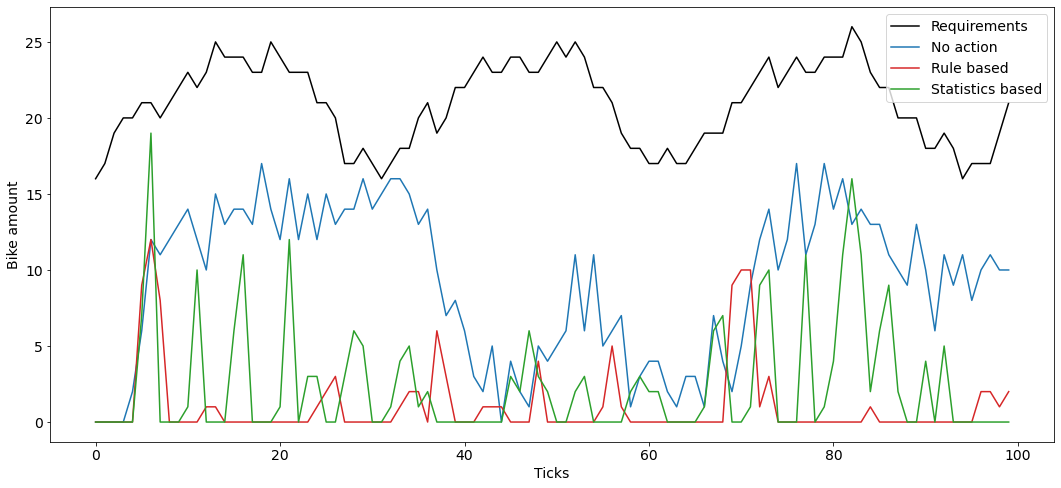

In [20]:
font = {'size'   : 14}

matplotlib.rc('font', **font)

tot_requirement = no_action_result["requirement"].sum(axis=1)
no_action_shortage = no_action_result["shortage"].sum(axis=1)
rule_based_shortage = rule_based_result["shortage"].sum(axis=1)
searched_statistics_shortage = statistics_result["shortage"].sum(axis=1)

plt.figure(figsize=(18,8))
ticks = np.arange(tot_requirement.shape[0])

plt.plot(ticks, tot_requirement, color="black", label=f"Requirements")
plt.plot(ticks, no_action_shortage, color="tab:blue", label=f"No action")
plt.plot(ticks, rule_based_shortage, color="tab:red", label=f"Rule based")
plt.plot(ticks, searched_statistics_shortage, color="tab:green", label=f"Statistics based")

plt.xlabel('Ticks')
plt.ylabel('Bike amount')
plt.legend()